In [1]:
import numpy as np
import json
import re
from collections import defaultdict
import spacy
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
annotation_file = '../vqa-dataset/Annotations/mscoco_%s_annotations.json'
annotation_sets = ['train2014', 'val2014']
question_file = '../vqa-dataset/Questions/OpenEnded_mscoco_%s_questions.json'
question_sets = ['train2014', 'val2014', 'test-dev2015', 'test2015']

vocab_file = './vocabulary_vqa.txt'
answer_file = './answers_vqa.txt'
glove_mat_file = './vocabulary_vqa_glove.npy'

num_answers = 3000

In [3]:
answer_counts = defaultdict(lambda: 0)
for image_set in annotation_sets:
    with open(annotation_file % image_set) as f:
        annotations = json.load(f)["annotations"]
    for ann in annotations:
        for answer in ann["answers"]:
#             if answer["answer_confidence"] != "yes":
#                 continue
            word = answer["answer"]
            if re.search(r"[^\w\s]", word):
                continue
            answer_counts[word] += 1

top_answers = sorted(answer_counts, key=answer_counts.get, reverse=True)
print('total answer num: %d, keeping top %d' % (len(top_answers), num_answers))
# add a <unk> symbol to represent the unseen answers.
assert('<unk>' not in top_answers)
answer_list = ['<unk>'] + top_answers[:num_answers]

total answer num: 121928, keeping top 3000


In [4]:
vocab_set = set()
SENTENCE_SPLIT_REGEX = re.compile(r'(\W+)')
question_length = []
for image_set in question_sets:
    with open(question_file % image_set) as f:
        questions = json.load(f)['questions']
    set_question_length = [None]*len(questions)
    for n_q, q in enumerate(questions):
        words = SENTENCE_SPLIT_REGEX.split(q['question'].lower())
        words = [w.strip() for w in words if len(w.strip()) > 0]
        vocab_set.update(words)
        set_question_length[n_q] = len(words)
    question_length += set_question_length

# although we've collected all words in the dataset,
# still add a <unk> for future-proof
vocab_set.add('<unk>')
print('total word num: %d, keeping all' % len(vocab_set))
vocab_list = list(vocab_set)
vocab_list.sort()

total word num: 17742, keeping all


In [5]:
with open(vocab_file, 'w') as f:
    f.writelines([w+'\n' for w in vocab_list])
with open(answer_file, 'w') as f:
    f.writelines([w+'\n' for w in answer_list])

In [6]:
# Collect glove vectors for the words
glove_dim = 300
glove_mat = np.zeros((len(vocab_list), glove_dim), np.float32)
nlp = spacy.load('en', vectors='en_glove_cc_300_1m_vectors')
for n, w in enumerate(vocab_list):
    glove_mat[n] = nlp(w).vector
np.save(glove_mat_file, glove_mat)

maximum question length: 26


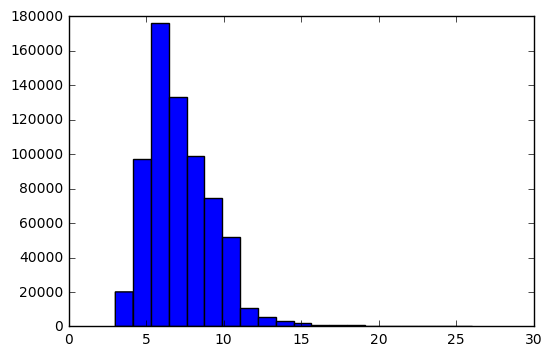

In [7]:
_ = plt.hist(question_length, bins=20)
print('maximum question length:', np.max(question_length))